<a href="https://colab.research.google.com/github/khandakerrahin/ML_image_search_engine/blob/main/MX_the_outliers_image_search_v4_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                                            The Outliers

In [91]:
import os
import time
import requests
import json
from datetime import datetime
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm
import PIL
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# importing models
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
# from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
# from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input


import math
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.decomposition import PCA

print('TensorFlow version:', tf.__version__)
print('Is using GPU?', False if tf.config.list_physical_devices('GPU') == [] else True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# print(tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.8.0
Is using GPU? True
Num GPUs Available:  1


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
%%capture
!unzip /content/drive/MyDrive/ML/challenge_test_data.zip

In [110]:
# Tweak these parameters as needed
query_dir = '/content/query'
root_dir = '/content'

batch_size = 64
img_size = 224

n_neighbors = 10 # for PCA
n_components = 500 # for PCA

submission_url = "http://coruscant.disi.unitn.it:3001/results/"

# use this to limit how many "query" results you want
query_limit = 3
limit_query = True

apply_pca_sim_both = False # Use Regular and PCA both similarities
apply_pca = True # Use PCA 

In [94]:
start = datetime.now()

# Importing Resnet50, a pretrained model
# model = ResNet50(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

# Importing ResNet50V2, a pretrained model
# model = ResNet50V2(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

# Importing VGG16, a pretrained model
# model = VGG16(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

# Importing VGG19, a pretrained model
# model = VGG19(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

# Importing InceptionV3, a pretrained model
model = InceptionV3(weights='imagenet', include_top=False,input_shape=(img_size, img_size, 3),pooling='max')

# Trying to use our own model that was created on top of Resnet50 using Transfer Learning
# model = tf.keras.models.load_model('models/model_0.459.h5')

# Trying to use our own model that was created on top of VGG16 using Transfer Learning
# model = tf.keras.models.load_model('models/model_0.719.h5')

# DOES NOT WORK YET: Trying to use our own model that was created on CNN
# model = tf.keras.models.load_model('models/model_0.677.h5')

Create the keras image data generator object and extract the features for the images.

In [95]:
#root_dir = 'dataset_rahin/final/gallery_team'
# root_dir = '/content/gallery_team'
# root_dir = '/content'


img_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

datagen = img_gen.flow_from_directory('.', classes=['gallery'],
                                        target_size=(img_size, img_size),
                                        batch_size=batch_size,
                                        class_mode=None,
                                        shuffle=False)

num_images = len(datagen.filenames)
num_epochs = int(math.ceil(num_images / batch_size))

feature_list = model.predict(datagen, num_epochs,verbose = 1)

print("Num images   = ", len(datagen.classes))
print("Shape of feature_list = ", feature_list.shape)


# Get full path for all the images in our Gallery Dataset

filenames = [root_dir + '/' + s for s in datagen.filenames]
# print(filenames)

# calculating Neighbors
neighbors = NearestNeighbors(n_neighbors=n_neighbors,
                             algorithm='ball_tree',
                             metric='euclidean')
neighbors.fit(feature_list)


# calculating Neighbors for PCA
pca = PCA(n_components=n_components)
pca.fit(feature_list)
compressed_features = pca.transform(feature_list)


neighbors_pca_features = NearestNeighbors(n_neighbors=n_neighbors,
                              algorithm='ball_tree',
                              metric='euclidean').fit(compressed_features)

duration = datetime.now() - start
print("Feature Extraction completed in: ", duration)

Found 6355 images belonging to 1 classes.
100/100 [==============================] - 36s 354ms/step
Num images   =  6355
Shape of feature_list =  (6355, 2048)
Feature Extraction completed in:  0:00:51.882363


In [96]:
# Creating methods

def similar_images(ind, dist, res_dict, query_img_name):
    plt.figure(figsize=(15,10), facecolor='white')
    plotnumber = 1    
#     print(len(ind))

    res_dict[query_img_name] = []
    for index in ind:
        if plotnumber<=len(ind) :
            ax = plt.subplot(2,5,plotnumber)
            plt.imshow(mpimg.imread(filenames[index]), interpolation='lanczos')
#             plt.xlabel(distance[plotnumber-1],fontsize=12)
            lbl = "top-" + str(plotnumber) + " : " + str(format(dist[plotnumber-1], '.2f'))
            plt.xlabel(lbl,fontsize=12)
            plotnumber+=1

            file_name_array = filenames[index].split('/')
            res_name = file_name_array[len(file_name_array)-1]

            res_dict[query_img_name].append(res_name)
            # print("res_name: ",res_name)
    plt.tight_layout()
    plt.show()
    print('\n' * 5)

def get_similar_images(query_img_path, indices, distances, res_dict):
    print("---------- Query Image --------")
    print("")
    
    plt.figure()
    plt.imshow(mpimg.imread(query_img_path), interpolation='lanczos')
    # plt.xlabel(img_path.split('.')[0] + '_Original Image',fontsize=20)
    
    file_name_array = query_img_path.split('/')
    query_img_name = file_name_array[len(file_name_array)-1]

    plt.xlabel('Query Image: ' + query_img_name,fontsize=12)
    plt.show()
    print()
    print('---------- Similar Images --------')
    print()
    similar_images(indices[0], distances[0], res_dict, query_img_name)
    
def get_simalar_images_pca(query_img_path, pca_indices, pca_distances, res_dict):
    print("---------- Query Image --------")
    print("")

    plt.figure()
    plt.imshow(mpimg.imread(query_img_path), interpolation='lanczos')
    # plt.xlabel(query_img_path.split('/')[3] + '_Original Image',fontsize=20)

    file_name_array = query_img_path.split('/')
    query_img_name = file_name_array[len(file_name_array)-1]

    plt.xlabel('Query Image: ' + query_img_name,fontsize=12)
    plt.show()
    print()
    print('---------- Similar Images after PCA --------')
    print()
    similar_images(pca_indices[0], pca_distances[0], res_dict, query_img_name)

def submit(results, url=submission_url):
    res = json.dumps(results)
    response = requests.post(url, res)
    try:
        result = json.loads(response.text)
        print(f"accuracy is {result['results']}")
    except json.JSONDecodeError:
        print(f"ERROR: {response.text}")

---------- Query Image --------



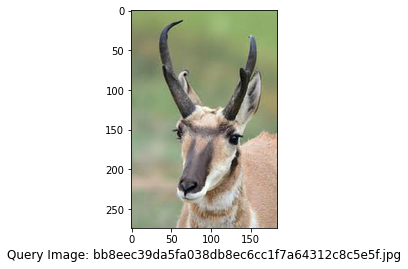


---------- Similar Images --------



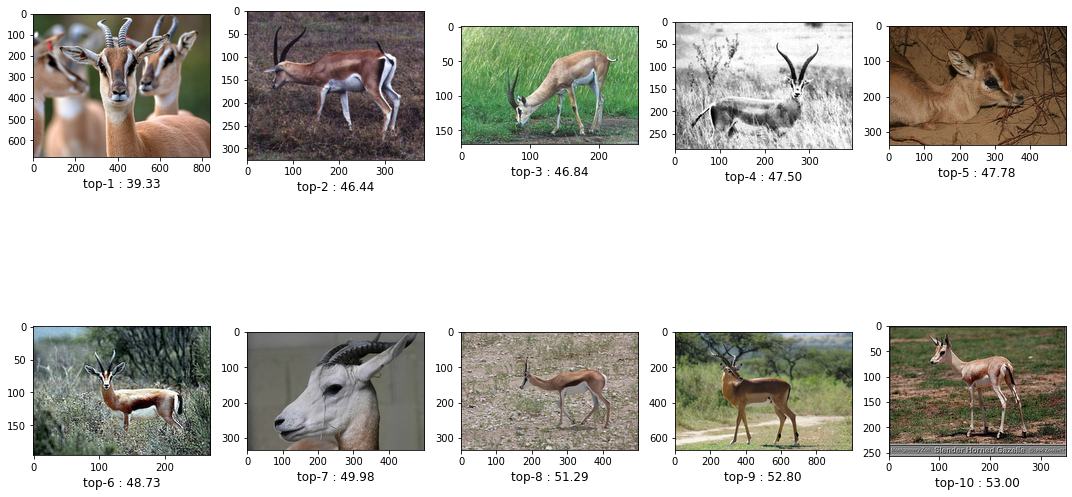







---------- Query Image --------



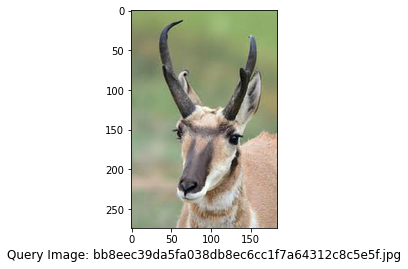


---------- Similar Images after PCA --------



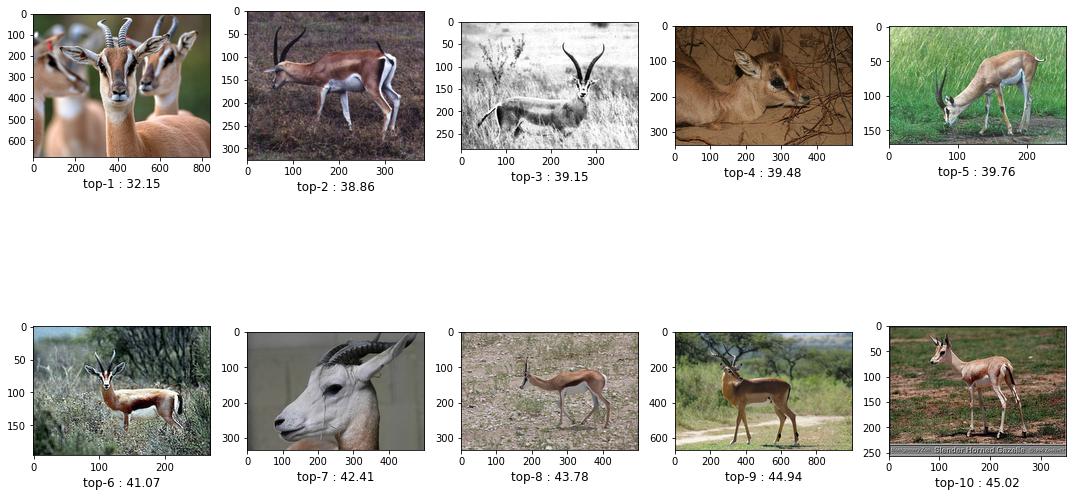







---------- Query Image --------



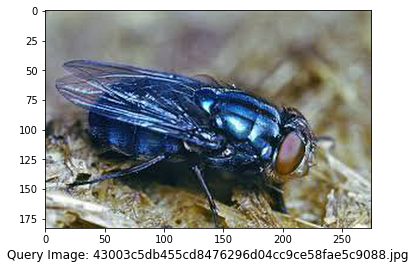


---------- Similar Images --------



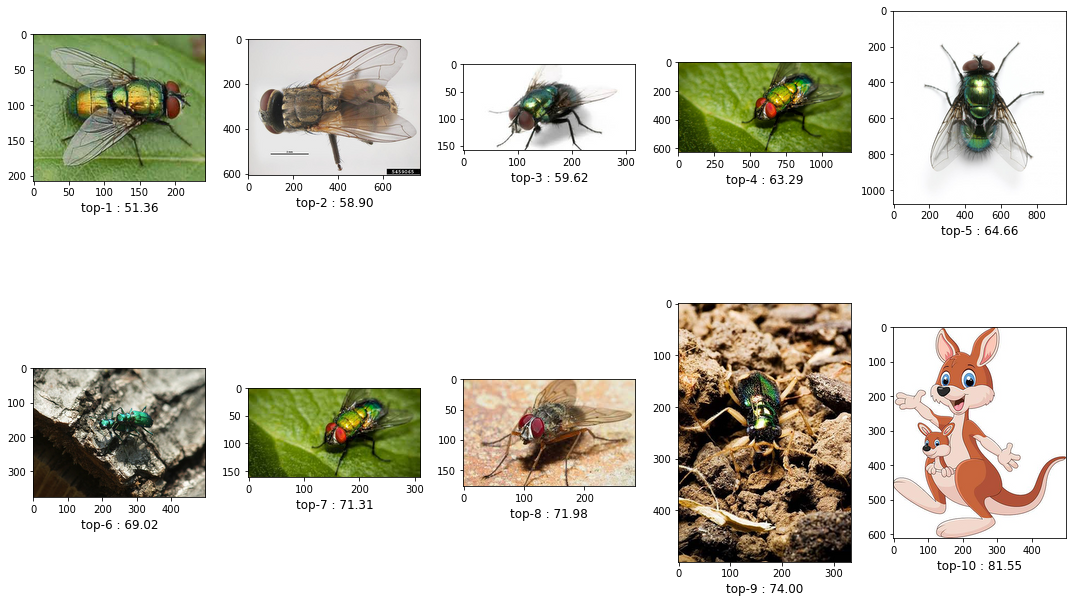







---------- Query Image --------



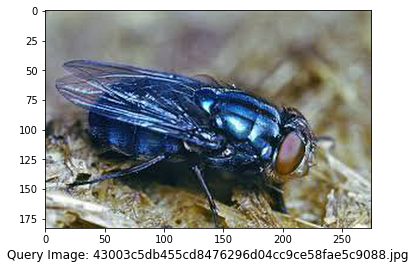


---------- Similar Images after PCA --------



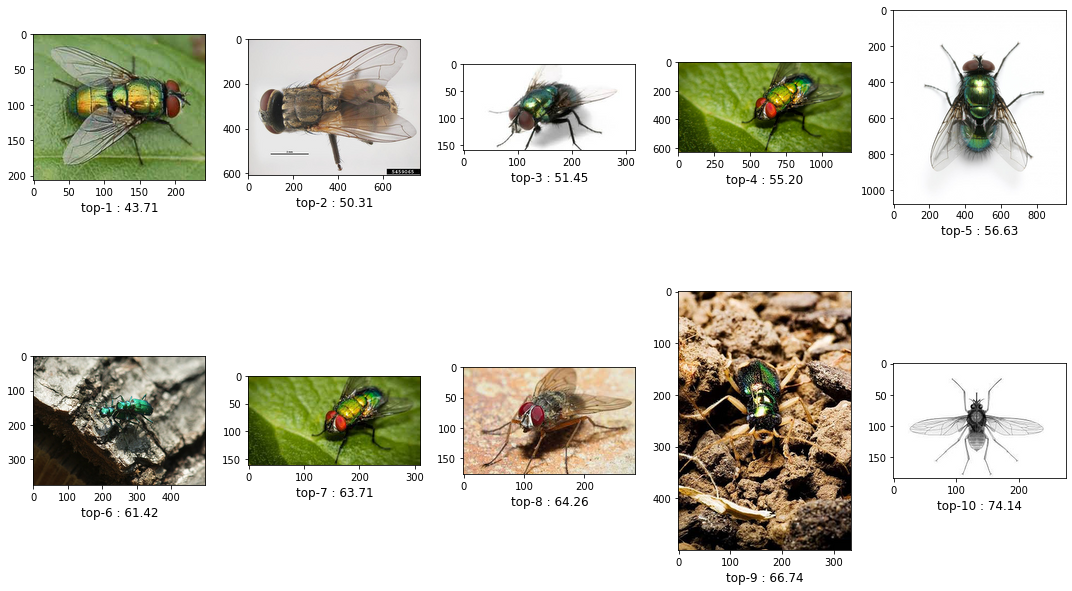







---------- Query Image --------



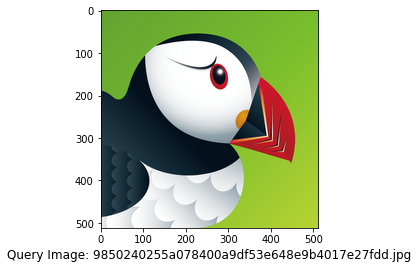


---------- Similar Images --------



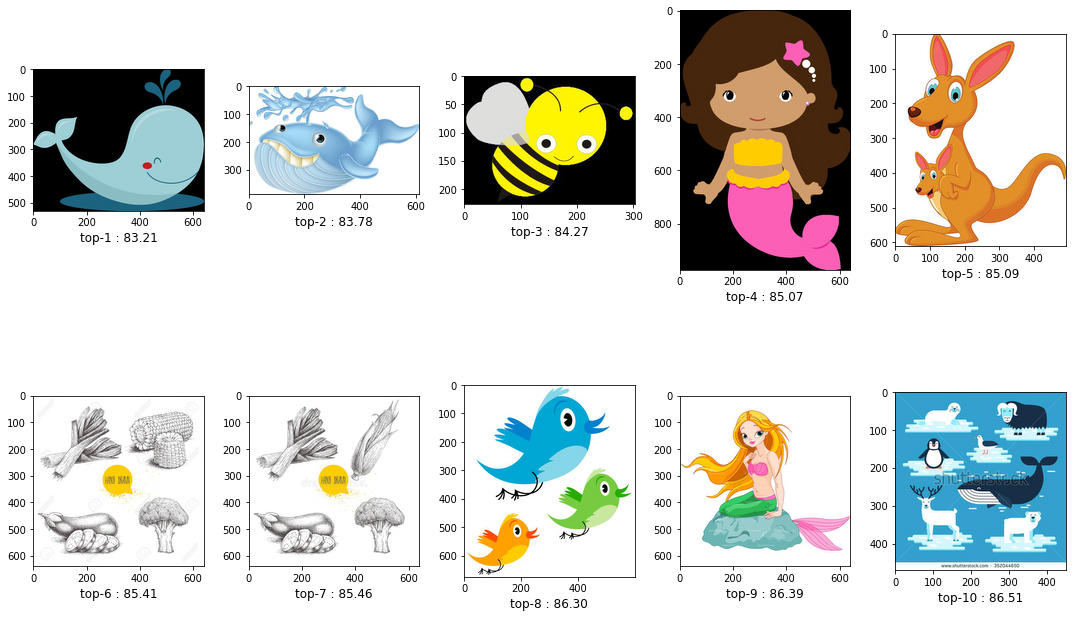







---------- Query Image --------



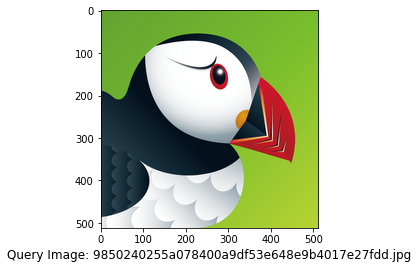


---------- Similar Images after PCA --------



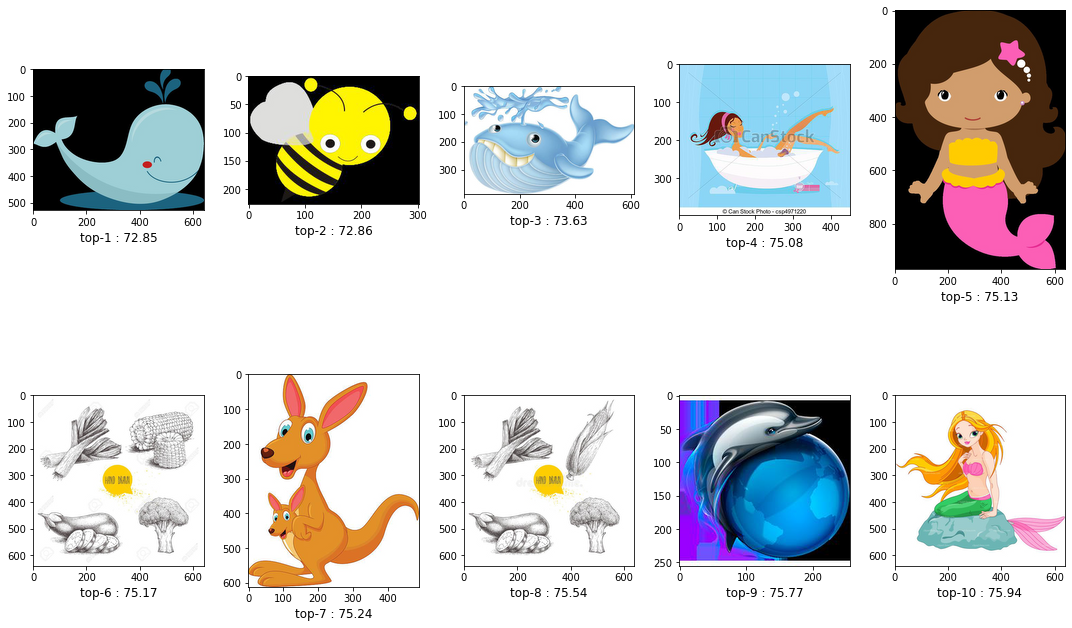

In [111]:
# query_img_path = 'dataset_rahin/final/query/2.png'
# query_dir = 'dataset_rahin/final/query_team/'
# query_dir = '/content/query'


# # use this to limit the loop to specific query count
idx_run = 0
# query_limit = 10


mydata = dict()
mydata['groupname'] = "The Outliers"

res = dict()

for filename in os.listdir(query_dir):

    # use this to limit the loop to specific query count
    if idx_run==query_limit and limit_query:
      break


    query_img_path = os.path.join(query_dir, filename)
    # checking if it is a file
    if os.path.isfile(query_img_path) and query_img_path.lower().endswith(('.jpg', '.jpeg', 'png')):
#         print(query_img_path)
#         plt.imshow(plt.imread(query_img_path))
#         plt.xlabel('Query Image: ' + query_img_path.split('/')[3],fontsize=12)
#         plt.show()

        input_shape = (img_size, img_size, 3)
        img = image.load_img(query_img_path, target_size=(input_shape[0], input_shape[1]))
        img_array = image.img_to_array(img)
        expanded_img_array = np.expand_dims(img_array, axis=0)
        preprocessed_img = preprocess_input(expanded_img_array)

        test_img_features = model.predict(preprocessed_img, batch_size=1)

        distances, indices = neighbors.kneighbors(test_img_features)

        # for dist in _:
        #     print(dist)

#         print(indices.shape)
        
        if apply_pca_sim_both:
          # Get Similar Images
          get_similar_images(query_img_path, indices, distances, res)

          # Get Similar Images after applying PCA

          test_img_compressed = pca.transform(test_img_features)
          pca_distances, pca_indices = neighbors_pca_features.kneighbors(test_img_compressed)
          # print(indices.shape)

          get_simalar_images_pca(query_img_path=query_img_path, pca_indices=pca_indices, pca_distances=pca_distances, res_dict=res)
          
        elif apply_pca:
          # Get Similar Images after applying PCA

          test_img_compressed = pca.transform(test_img_features)
          pca_distances, pca_indices = neighbors_pca_features.kneighbors(test_img_compressed)
          # print(indices.shape)

          get_simalar_images_pca(query_img_path=query_img_path, pca_indices=pca_indices, pca_distances=pca_distances, res_dict=res)
        else:
          # Get Similar Images
          get_similar_images(query_img_path, indices, distances, res)
        
        # use this to limit the loop to specific query count
        idx_run = idx_run + 1
        
#         TODO implement server api to get results


In [90]:
# import json
# print(json.dumps(res, indent=4))

# print(json.dumps(res["bb8eec39da5fa038db8ec6cc1f7a64312c8c5e5f.jpg"], indent=4))

mydata["images"] = res

print(json.dumps(mydata, indent=4))
# submit(mydata)


{
    "groupname": "The Outliers",
    "images": {
        "bb8eec39da5fa038db8ec6cc1f7a64312c8c5e5f.jpg": [
            "67a7485bc2bfa9dd50173ae6fd1188303f5938d2.jpg",
            "bd1c944cbc7a8db3b0f929ae3398d5681559689b.jpg",
            "42030db7df093744912709d4b08757e20a3a7bc2.jpg",
            "817ef8fbecd483d8ea426bb32900d53c77006fad.jpg",
            "f4674decc4a616dcd4b34a913148e7f45465ddf8.jpg",
            "725917cc2e378742906a156c33b75f812df3ae8f.jpg",
            "967370b8d81249b80975be5ed25b0cc8d9dc793a.jpg",
            "c242d21fd8b8a123b59c52385349a2972a07a5cd.jpg",
            "6ce7e8dda2d5b5dd8e5029c070e178094aa1cf81.jpg",
            "21a2ed48cdba5ccaee07bf9af57d617bedc1cac6.jpg"
        ],
        "43003c5db455cd8476296d04cc9ce58fae5c9088.jpg": [
            "de12af05ffa2938be6e2c7ffe47e8af8b53a9385.jpg",
            "262fc77eb11a5de8637e382a06764123b1dbeea1.jpg",
            "1d191552cdc8632317ebb3fe8187d78d5a608028.jpg",
            "1250ed117728aa6bc48138615e1a9f